### Overview of the patent landscape of KGs

#### Import modules

In [1]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import string

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

### Loading data files

In [3]:
DATA_DIR = '../data/patent_dumps'
FIG_DIR = '../data/figures'

In [4]:
rare_disease_data = pd.read_csv(f'{DATA_DIR}/orphanet_normalized_patent_data.tsv', sep='\t')
rare_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person
0,CHEMBL3137316,SCHEMBL1707427,US-20140316139-A1,2014-10-23,C07D 213/89,PFIZER,Pfizer,NaN,NaN
1,CHEMBL3137316,SCHEMBL1707427,US-20140142316-A1,2014-05-22,C07D 213/89,PFIZER,Pfizer,NaN,NaN


In [5]:
alzheimer_disease_data = pd.read_csv(f'{DATA_DIR}/ad_normalized_patent_data.tsv', sep='\t')
alzheimer_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person
0,CHEMBL1460470,SCHEMBL14919618,US-20140256767-A1,2014-09-11,C07D 401/14,UNIV RUTGERS,Rutgers University,NaN,NaN
1,CHEMBL1460470,SCHEMBL14919618,US-20180148408-A1,2018-05-31,C07D 209/48,UNIV RUTGERS,Rutgers University,NaN,NaN


In [6]:
rare_disease_data.shape, alzheimer_disease_data.shape

((17506, 9), (76321, 9))

In [7]:
rare_disease_data = rare_disease_data[~rare_disease_data['assignee'].isna()]
rare_disease_data.shape

(17375, 9)

In [8]:
alzheimer_disease_data = alzheimer_disease_data[~alzheimer_disease_data['assignee'].isna()]
alzheimer_disease_data.shape

(75616, 9)

Number of unique modulators

In [9]:
len(rare_disease_data['surechembl'].unique())

585

In [10]:
len(alzheimer_disease_data['surechembl'].unique())

22930

Number of unique patent documents

In [11]:
len(rare_disease_data['patent_id'].unique())

502

In [12]:
len(alzheimer_disease_data['patent_id'].unique())

13181

### Creating IPC code counter dataframe

In [13]:
def get_ipc_df(df: pd.DataFrame):
    """Create a IPC count based dataframe."""
    
    data = defaultdict(set)
    
    for patent_id, ipc_code in tqdm(df[['patent_id', 'ipc']].values):
        ipc = ipc_code.split()[0]
        data[ipc].add(patent_id)
        
    data = [
        {'ipc': code, 'patent_count': len(patent_docs)}
        for code, patent_docs in data.items()
    ]
    
    return pd.DataFrame(data)
    

In [14]:
rare_disease_ipc_df = get_ipc_df(rare_disease_data)
rare_disease_ipc_df.sort_values('patent_count', ascending=False, inplace=True)
rare_disease_ipc_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 328649.40it/s]


,ipc,patent_count
0,C07D,294
3,C07J,61


In [15]:
alzheimer_disease_ipc_df = get_ipc_df(alzheimer_disease_data)
alzheimer_disease_ipc_df.sort_values('patent_count', ascending=False, inplace=True)
alzheimer_disease_ipc_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 443433.49it/s]


,ipc,patent_count
0,C07D,9240
4,C07C,858


### IPC Code mapping

In [16]:
IPC_CODE_MAPPER = {
    'A23B': 'Preservaties',
    'A23C': 'Dairy products',
    'A23D': 'Edible oil',
    'A23F': 'Coffee and tea',
    'A23G': 'Coca products',
    'A23J': 'Food protein composition',
    'A23L': 'Food and beverages',
    'A61B': 'Diagnosis and surgery',
    'A61C': 'Oral hygiene',
    'A61D': 'Veterinary instruments',
    'A61P': 'Theraupeutic activity',
    'A61Q': 'Cometic prepartion',
    'C01B': 'Non-metallic',
    'C01G': 'Metallic',
    'C07B': 'Organic chemistry',
    'C07C': 'Acyclic or carbocyclic',
    'C07D': 'Heterocyclic',
    'C07F': 'Presence of specific element',
    'C07G': 'Unknown subsitution',
    'C07H': 'Sugar derivatives',
    'C07J': 'Steroids',
    'C07K': 'Peptides',
    'C08B': 'Polysaccharides',
    'C08C': 'Modifications of rubber',
    'C08F': 'Macromolecules from reactions',
    'C08G': 'Macromolecules',
    'C08J': 'Compound processing',
    'C08K': 'Non-macromolecular',
    'C08L': 'Macromolecular composition',
    'C12P': 'Fermentation induced',
    'C12Q': 'Microbiologically tested'
}

In [17]:
rare_disease_ipc_df['ipc'] = rare_disease_ipc_df['ipc'].map(IPC_CODE_MAPPER)
alzheimer_disease_ipc_df['ipc'] = alzheimer_disease_ipc_df['ipc'].map(IPC_CODE_MAPPER)

### Generate patent status dataframe

In [18]:
def get_status_df(df: pd.DataFrame):
    """Create a patent status based dataframe."""
    
    data = defaultdict(set)
    
    for patent_id in tqdm(df[['patent_id']].values):
        status = patent_id[0].split('-')[-1]
        
        # Trimming status to be A/B only
        status = status[0]
        
        if status == 'A':
            status = 'Pending'
        elif status == 'B' or 'E': # E = reissued patent
            status = 'Granted'
        else:
            print(patent_id, status)
            continue
        
        data[status].add(patent_id[0])
        
    data = [
        {'status': pat_status, 'patent_count': len(patent_docs)}
        for pat_status, patent_docs in data.items()
    ]
    
    return pd.DataFrame(data)

In [19]:
rare_disease_status_df = get_status_df(rare_disease_data)
rare_disease_status_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 849767.16it/s]


,status,patent_count
0,Pending,322
1,Granted,180


In [20]:
alzheimer_disease_status_df = get_status_df(alzheimer_disease_data)
alzheimer_disease_status_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 661819.53it/s]


,status,patent_count
0,Pending,9201
1,Granted,3980


### Visalizing the results

In [21]:
mpl.rcParams['figure.dpi'] = 400

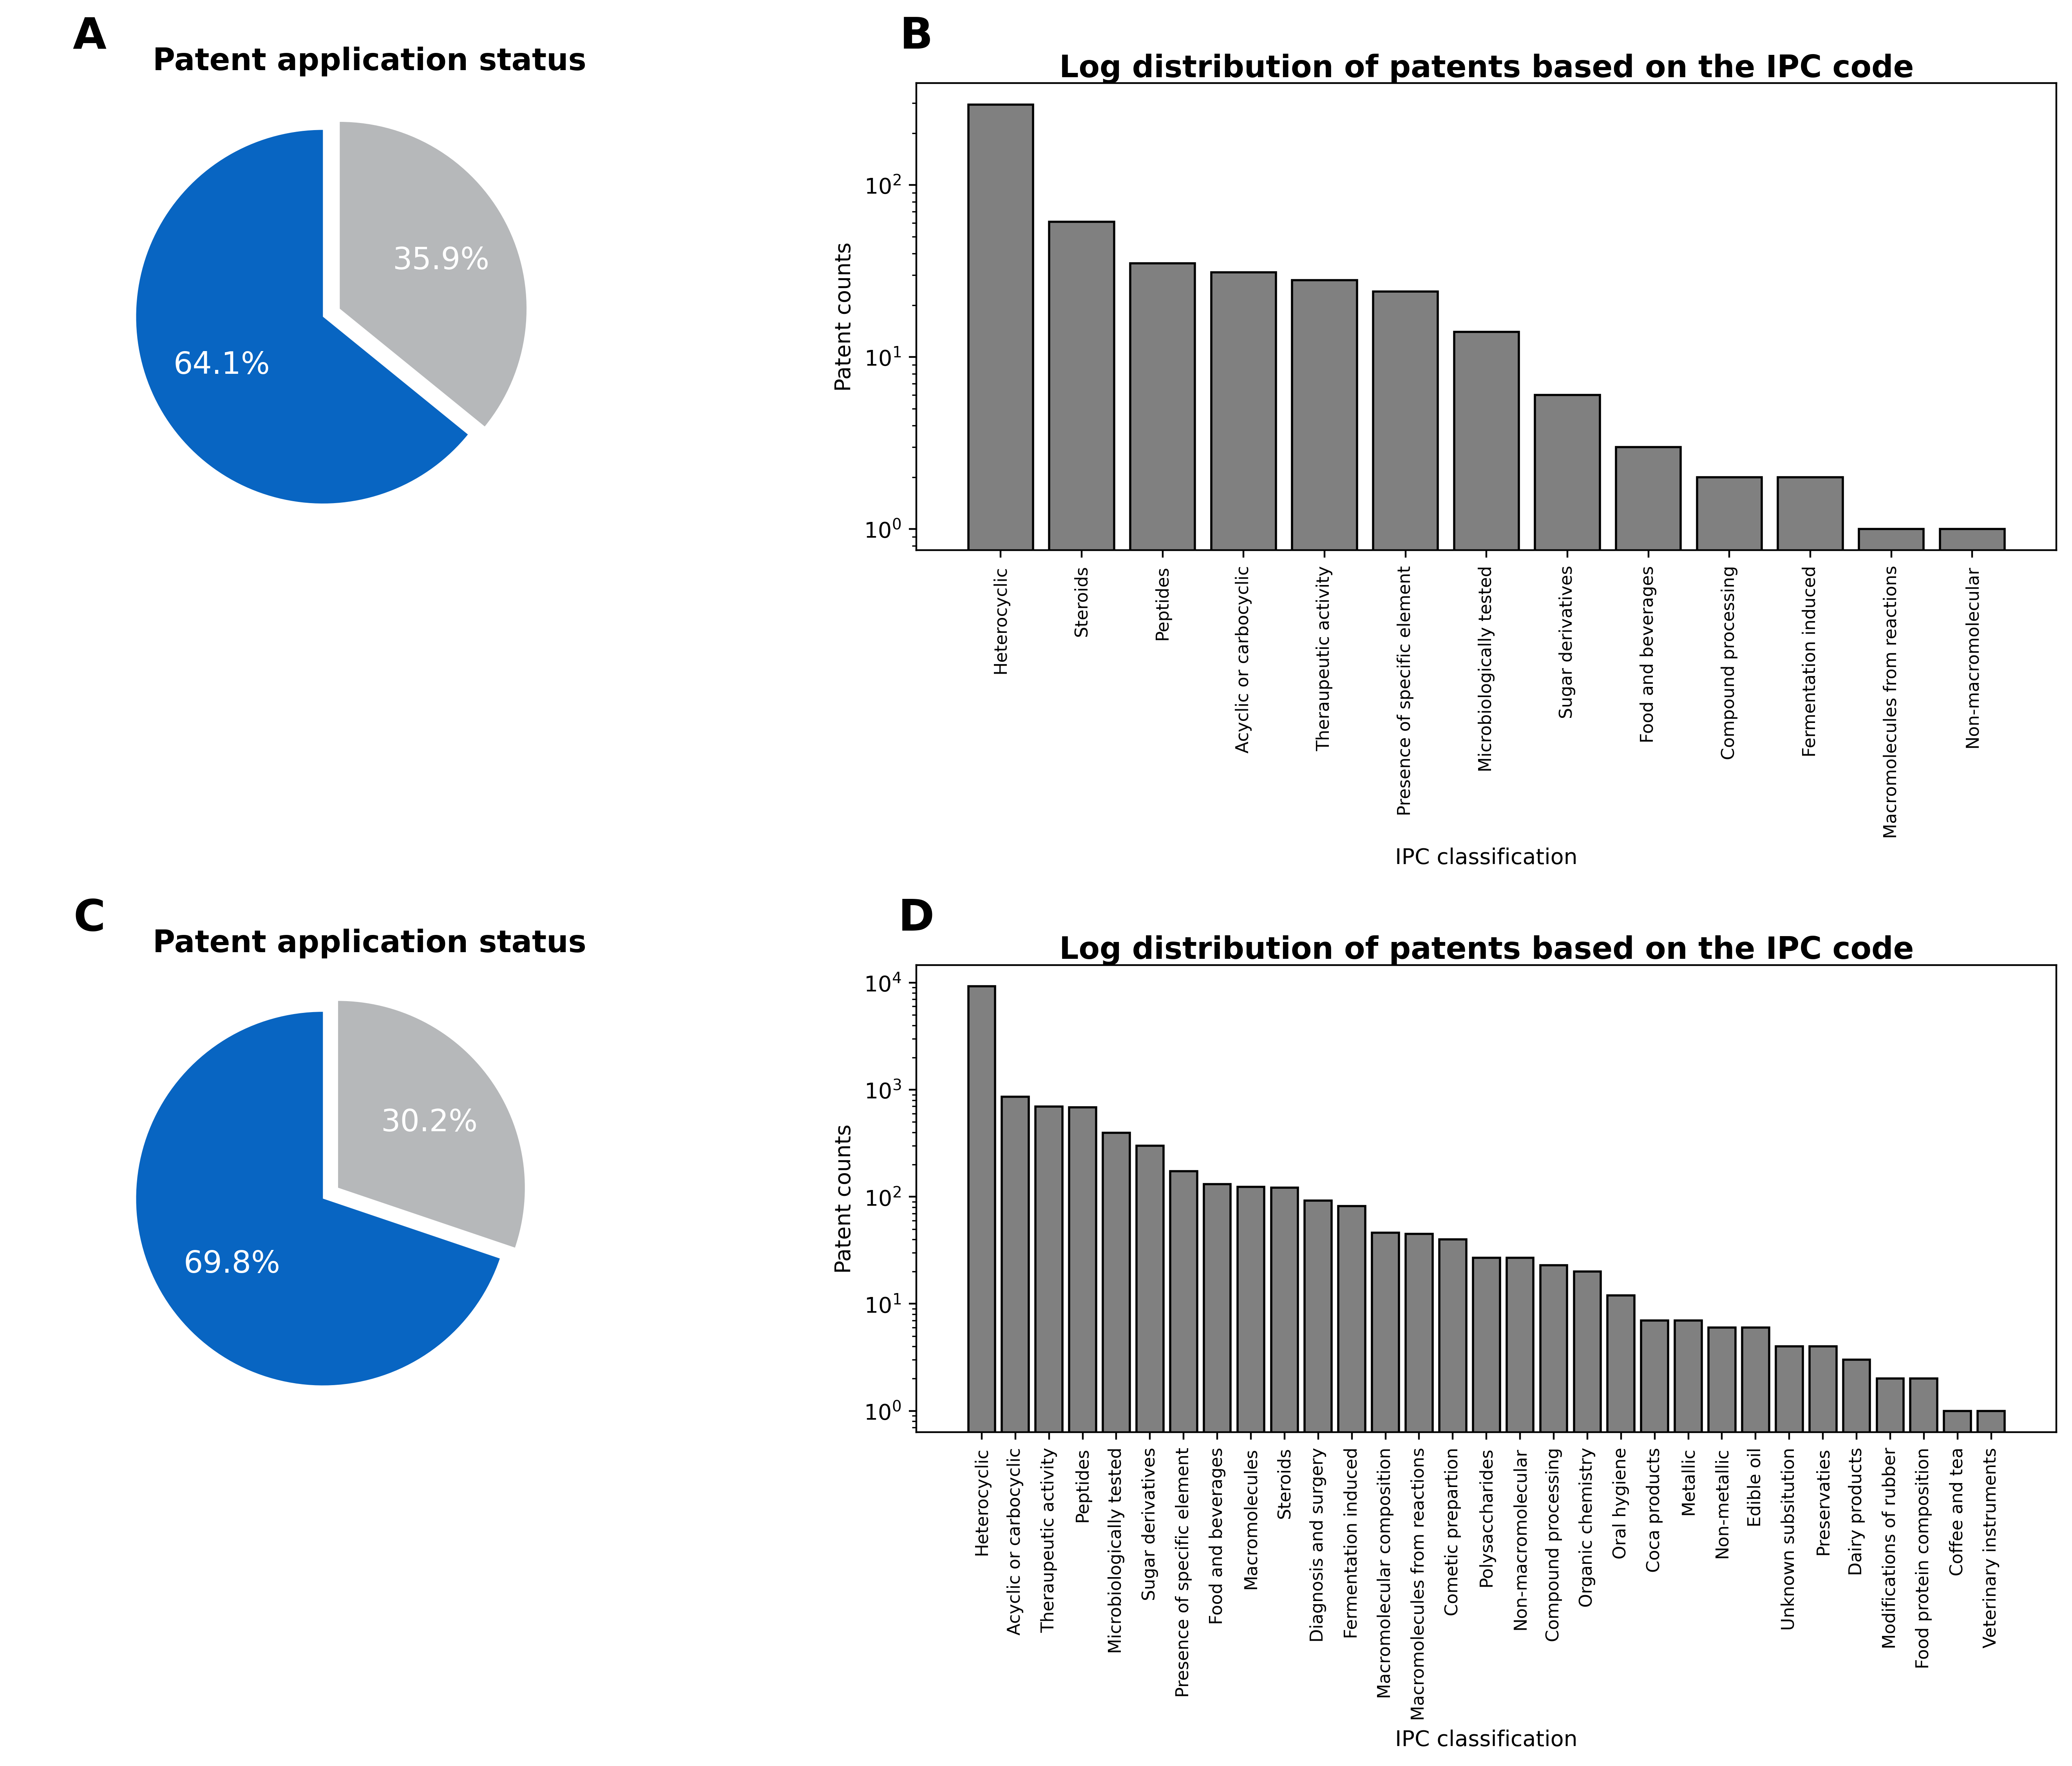

In [22]:
plt.figure(figsize=([15,15]))

plt.subplots_adjust(wspace=0)

# Pie chart for rare disease - Patent status
plt.subplot(3,2,1)
plt.pie(
    rare_disease_status_df.patent_count.to_list(), 
    explode=(0, 0.1), 
    labels=rare_disease_status_df.status, 
    autopct='%1.1f%%',
    startangle=90,
    colors=['#0865c2','#b6b8ba'],
    textprops={'fontsize': 14, 'color': 'white'}
)
plt.title(
    'Patent application status',
    y=1.0, size=14, x=0.6, weight='bold',
)
plt.text(0, 1.1, string.ascii_uppercase[0],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

# Histogram for rare disease - IPC classification
plt.subplot(3,2,2)
plt.bar(
    x=rare_disease_ipc_df.ipc,
    height=rare_disease_ipc_df.patent_count,
    edgecolor='black', 
    color='grey',
    log=True
)
plt.ylabel('Patent counts')
plt.xlabel('IPC classification')
plt.xticks(rotation=90, fontsize=8)
plt.title(
    'Log distribution of patents based on the IPC code',
    horizontalalignment='center', size=14,
    verticalalignment='center', weight='bold'
)
plt.text(0, 1.1, string.ascii_uppercase[1],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

# Pie chart for alzheimers - Patent status
plt.subplot(3,2,3)
plt.pie(
    alzheimer_disease_status_df.patent_count.to_list(), 
    explode=(0, 0.1), 
    labels=alzheimer_disease_status_df.status, 
    autopct='%1.1f%%',
    startangle=90,
    colors=['#0865c2','#b6b8ba'],
    textprops={'fontsize': 14, 'color': 'white'}
)
plt.title(
    "Patent application status",
    y=1.0, size=14, x=0.6, weight='bold',
)
plt.text(0, 1.1, string.ascii_uppercase[2],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

# Histogram for alzheimers - IPC classification
plt.subplot(3,2,4)
plt.bar(
    x=alzheimer_disease_ipc_df.ipc,
    height=alzheimer_disease_ipc_df.patent_count,
    edgecolor='black', 
    color='grey',
    log=True
)
plt.ylabel('Patent counts')
plt.xlabel('IPC classification')
plt.xticks(rotation=90, fontsize=8)
plt.title(
    "Log distribution of patents based on the IPC code",
    horizontalalignment='center', size=14,
    verticalalignment='center', weight='bold'
)
plt.text(0, 1.1, string.ascii_uppercase[3],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)


plt.tight_layout()
plt.savefig(f'{FIG_DIR}/figure_2.png', bbox_inches='tight', dpi=400)
plt.show()

### Percentages for main IPC classes

In [23]:
total_patent_count = sum(rare_disease_ipc_df.patent_count.to_list())
for ipc_code, patent_count in rare_disease_ipc_df[:6].values:
    print(ipc_code, '-', round(patent_count / total_patent_count, 2))

Heterocyclic - 0.59
Steroids - 0.12
Peptides - 0.07
Acyclic or carbocyclic - 0.06
Theraupeutic activity - 0.06
Presence of specific element - 0.05


In [24]:
total_patent_count = sum(alzheimer_disease_ipc_df.patent_count.to_list())
for ipc_code, patent_count in alzheimer_disease_ipc_df[:6].values:
    print(ipc_code, '-', round(patent_count / total_patent_count, 2))

Heterocyclic - 0.7
Acyclic or carbocyclic - 0.07
Theraupeutic activity - 0.05
Peptides - 0.05
Microbiologically tested - 0.03
Sugar derivatives - 0.02


### Patent-modulator overview: US-centric patents only

In [25]:
def get_patent_modulator_df(df: pd.DataFrame):
    """Get dataframe with modulators linked to a patent."""
    
    data = defaultdict(set)
    
    for modulator, patent_num in tqdm(df[['surechembl', 'patent_id']].values):
        data[patent_num].add(modulator)
        
    data = [
        {'patent_id': pat_num, 'modulator_count': len(modulators)}
        for pat_num, modulators in data.items()
    ]
    
    mod_df = pd.DataFrame(data)
    
    return mod_df.describe()

In [26]:
us_rare_disease_data = rare_disease_data[rare_disease_data['patent_id'].str.contains('US-')]
us_rare_disease_data.shape

(9254, 9)

In [27]:
get_patent_modulator_df(us_rare_disease_data)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9254/9254 [00:00<00:00, 637414.63it/s]


,modulator_count
count,258.000000
mean,5.232558
std,11.477274
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,63.000000


In [28]:
us_alzheimer_disease_data = alzheimer_disease_data[alzheimer_disease_data['patent_id'].str.contains('US-')]
us_alzheimer_disease_data.shape

(42520, 9)

In [29]:
get_patent_modulator_df(us_alzheimer_disease_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42520/42520 [00:00<00:00, 631077.27it/s]


,modulator_count
count,6993.000000
mean,6.080366
std,23.426173
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,1160.000000
